**About BERTopic**

BERTopic was initially introduced in this [paper](https://doi.org/10.48550/arXiv.2203.05794).

BERTopic extends the idea of approaching topic modelling as a clustering task by using pre-trained transformer-based language models to embed each document.

More specifically, BERTopic generates document embedding with *pre-trained transformer-based language models*, clusters these embeddings using *UMAP* for dimensionality reduction and *HDBSCAN* to generate the clusters, and finally, generates topic representations with a *class-based TF-IDF* procedure.

**Running BERTopic on a GPU**

*BERTopic* offers GPU support by using the *cuml* package. However, this package can only be installed using the RAPIDS framework that requires itself an install through *conda* or *Docker*.
Please check the "Can I use the GPU to speed up the model?" section from the [BERTopic FAQ](https://maartengr.github.io/BERTopic/faq.html#how-can-i-run-bertopic-without-an-internet-connection) if you are interested in running the code below on your GPU.

In [11]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
from bertopic import BERTopic

from tripadvisor_hotel_reviews_topic_modeling.bert_topic import BERTopicLabel
from tripadvisor_hotel_reviews_topic_modeling.data_processing import get_data

In [2]:
DATA_DIR = Path().resolve().parent.joinpath("data")

In [3]:
df = get_data(
    dataset="andrewmvd/trip-advisor-hotel-reviews",
    filename="tripadvisor_hotel_reviews.csv",
)

In [4]:
df.columns = df.columns.str.lower()

In [5]:
label_dict = {1: "negative", 2: "negative", 3: "neutral", 4: "positive", 5: "positive"}
df["label"] = df["rating"].map(label_dict)

# 1. Data Exploration

In [6]:
df.head()

,review,rating,label
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


## 1.1. Rating Distribution

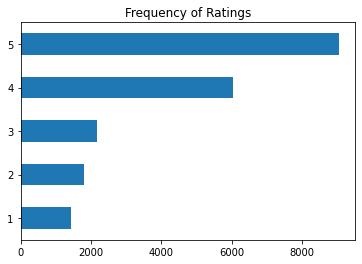

In [7]:
df["rating"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Ratings")
plt.show()

## 1.2. Reviews Length

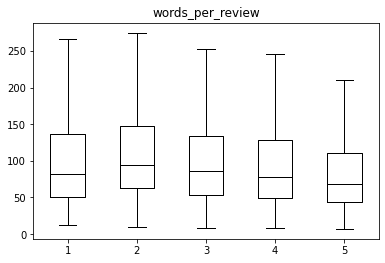

In [8]:
df["words_per_review"] = df["review"].str.split().apply(len)
df.boxplot("words_per_review", by="rating", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

For each rating most reviews are around 75-80 words long. 

# 2. BERTopic

In [9]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# for label in df["label"].unique():
for label in ["positive", "negative"]:
    df_label = df.loc[df["label"] == label, "review"]
    df_label = df_label.reset_index(drop=True)
    topics_label, probs_label = topic_model.fit_transform(df_label)
    joblib.dump(topic_model, DATA_DIR.joinpath(f"./topic_model_{label}.pkl"))
    joblib.dump(topics_label, DATA_DIR.joinpath(f"./topics_label_{label}.pkl"))
    joblib.dump(probs_label, DATA_DIR.joinpath(f"./probs_label_{label}.pkl"))

Batches: 100%|██████████| 472/472 [13:30<00:00,  1.72s/it] 
2022-07-01 19:45:45,551 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-07-01 19:46:12,981 - BERTopic - Reduced dimensionality
2022-07-01 19:46:20,402 - BERTopic - Clustered reduced embeddings
Batches: 100%|██████████| 101/101 [02:53<00:00,  1.72s/it]
2022-07-01 19:49:28,353 - BERTopic - Transformed documents to Embeddings
2022-07-01 19:49:43,184 - BERTopic - Reduced dimensionality
2022-07-01 19:49:43,594 - BERTopic - Clustered reduced embeddings


## 2.1. Getting the topics for negative reviews

Not that in the following, topic -1 groups all the "outliers", the reviews that couldn't be assigned to a cluster.

The *BERTopicLabel* object also generates the topic model, topic labels and probs object from the seraliased file to avoid having to retrain each time the kernel gets restarted.

In [12]:
bert_topic_label = BERTopicLabel(label="negative", data=df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anita.clementrvu.co.uk/github/data/topic_model_negative.pkl'

In [ ]:
bert_topic_label.get_number_topic()

In [ ]:
bert_topic_label.get_topn_topic_info(n_topic=10)

In [ ]:
bert_topic_label.get_dendrogram()

From the dendrogram above, we could group our topics into 12 main topics (the 2 green ones, the 3 red ones, the 3 light blue ones, the 2 brown ones and the 2 yellow ones).

In [ ]:
bert_topic_label.reduce_topic_number(n_topic=12)

We can now get the top 5 words for each topic to try to understand better what each topic is about! 

In [ ]:
bert_topic_label.get_barchart_top5words_by_topic()

It seems that a lot of reviews were clustered by location (Amsterdam, Barcelona, etc.). 

We can try to give a name to each topic although it is not always clear from the top 5 words what it is really about. Looking at few examples from each topic could help.
- Topic 0: Room & Location
- Topic 1: Food & Beach
- Topic 2: San Juan & Room 
- Topic 3: Amsterdam & Room & Location
- Topic 4: Noise & Room
- Topic 5: Barcelona & Room
- Topic 6: Westin Seattle & Room
- Topic 7: Singapore & Hong Kong & Room
- Topic 8: Room & Disappointment
- Topic 9: Dirt & Smell & Room & Bathroom & Shower
- Topic 10: Food & Service
- Topic 11: Price & Booking

In [ ]:
negative_reviews_predicted_topic = bert_topic_label.get_topic_review()

PosixPath('/Users/anita.clementrvu.co.uk/github/tripadvisor-hotel-reviews-topic-modeling/data/topic_model_ok.pkl')

In [ ]:
bert_topic_label.get_sample_reviews_for_topic(
    topic_review_df=negative_reviews_predicted_topic, topic_nb=11, nb_reviews=3
)

## 2.2. Getting the topics for positive reviews

In [ ]:
bert_topic_label = BERTopicLabel(label="positive", data=df)

In [ ]:
bert_topic_label.get_number_topic()

In [ ]:
bert_topic_label.get_topn_topic_info(n_topic=10)

In [ ]:
bert_topic_label.get_dendrogram()

In [ ]:
bert_topic_label.reduce_topic_number(n_topic=13)

In [ ]:
bert_topic_label.get_barchart_top5words_by_topic()

As for the negative reviews it seems that a lot of reviews were clustered by location (Barcelona, Paris, etc.). 

We can try to give a name to each topic although it is not always clear from the top 5 words what it is really about. Looking at few examples from each topic could help.
- Topic 0: Beach & Food
- Topic 1: Barcelona & Ramblas & Food
- Topic 2: Paris & Metro & Staff
- Topic 3: Florence & Breakfast
- Topic 4: NYC
- Topic 5: Amsterdam & Location
- Topic 6: New Orleans
- Topic 7: Location & Staff
- Topic 8: Seattle downtown
- Topic 9: San Francisco & Location
- Topic 10: Sydney & Harbour
- Topic 11: London & Tube & Breakfast
- Topic 12: Waikiki & Beach view

In [ ]:
positive_reviews_predicted_topic = bert_topic_label.get_topic_review()

In [ ]:
bert_topic_label.get_sample_reviews_for_topic(
    topic_review_df=positive_reviews_predicted_topic, topic_nb=0, nb_reviews=3
)